In [ ]:
#---- Set Up Library ------
from typing import List
import pandas as pd
pd.set_option("display.max_columns",None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import StandardScaler
# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

# Import min-max scaling function
from sklearn.preprocessing import MinMaxScaler

# Import keras lstm model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

# Read Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df_store = pd.read_csv("/content/drive/MyDrive/INDONESIA.AI/DATASET/PROJECT 1/store5.csv")

# Data Quality

In [ ]:
df_store.head()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.0,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.0,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.0,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.0,0,NaN
4,1456,2013-01-01,5,BOOKS,0.0,0,NaN


In [ ]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55572 entries, 0 to 55571
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           55572 non-null  int64  
 1   date         55572 non-null  object 
 2   store_nbr    55572 non-null  int64  
 3   family       55572 non-null  object 
 4   sales        55572 non-null  float64
 5   onpromotion  55572 non-null  int64  
 6   dcoilwtico   38379 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 3.0+ MB


In [ ]:
#--- drop uncessary columns ----
cols_drop = ["id","store_nbr","dcoilwtico"]
df = df_store.drop(cols_drop,axis=1)

In [ ]:
#--- convert data to datatime ----
df["date"] = pd.to_datetime(df["date"],format="%Y-%m-%d")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55572 entries, 0 to 55571
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         55572 non-null  datetime64[ns]
 1   family       55572 non-null  object        
 2   sales        55572 non-null  float64       
 3   onpromotion  55572 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [ ]:
#---- create function for filtering ----
def filter_family(df: pd.DataFrame,family:str) -> pd.DataFrame:
    filtered_df = df[df["family"]==family].reset_index(drop=True)
    return filtered_df


#---- function adfuller test with looping d ---
def adfuller_test(df : pd.Series, p: int) -> None:
    if p == 0:
        result = adfuller(df.dropna())
        print("No Differencing")
        print(f"p-value : {result[1]}")
    else:
        diff_df = df.copy()
        for i in range(p + 1):
            if i == 0:
                result = adfuller(diff_df.dropna())
                print(f"Differencing level {i}")
                print(f"p-value : {result[1]}")
            else:
                diff_df = diff_df.diff().dropna().reset_index(drop=True)
                result = adfuller(diff_df.dropna())
                print(f"Differencing level {i}")
                print(f"p-value : {result[1]}")


<Axes: ylabel='family'>

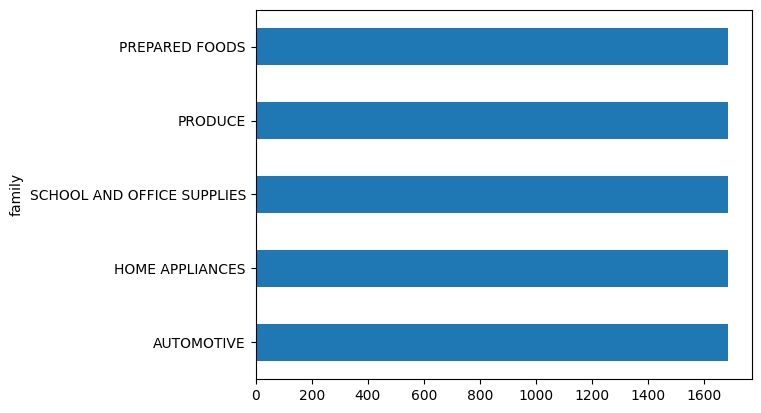

In [ ]:
#--- check----
df.family.value_counts().nlargest().plot(kind="barh")

# PREPARED FOODS EDA

In [ ]:
df_automotive = filter_family(df,"AUTOMOTIVE")
df_automotive.head()

,date,family,sales,onpromotion
0,2013-01-01,AUTOMOTIVE,0.0,0
1,2013-01-02,AUTOMOTIVE,6.0,0
2,2013-01-03,AUTOMOTIVE,4.0,0
3,2013-01-04,AUTOMOTIVE,6.0,0
4,2013-01-05,AUTOMOTIVE,4.0,0


<Axes: xlabel='date'>

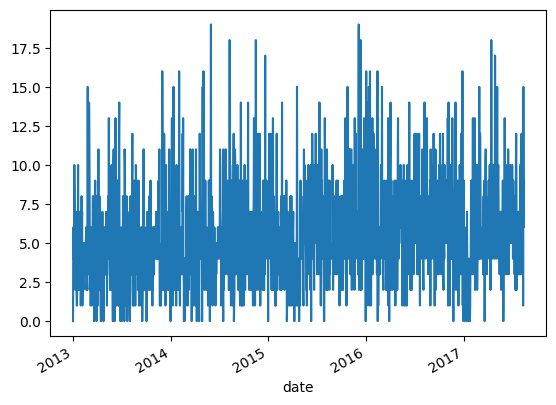

In [ ]:
df_automotive.set_index("date").sales.plot()

pada *family prepared food* row index - 0 berisikan 0, sehingga kita akan memfilter row index - 0

<Axes: xlabel='date'>

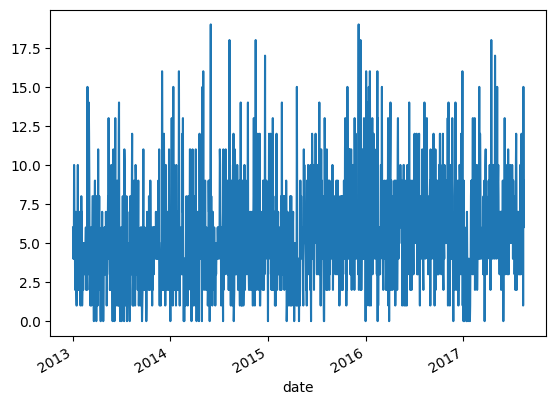

In [ ]:
df_automotive.iloc[1:,:].reset_index(drop=True).set_index("date").sales.plot()

<Axes: xlabel='date'>

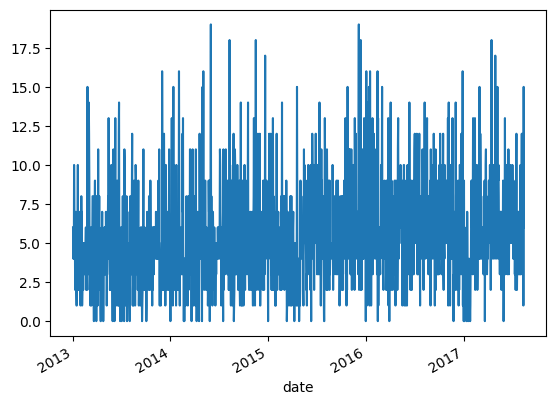

In [ ]:
#data belum full pada 2017-08-14
df_automotive = df_automotive.iloc[1:-1,:].reset_index(drop=True)
df_automotive.set_index("date").sales.plot()

Kita mengetahui terdapat pola yang berulang dimana sales dari PREPARED FOODS tidak memiliki sales pada tiap awal tahun dan terdapat pola yang seasonal. disini kita akan melakukan pendekatan aggregate perminggu untuk mengatasi data yang 0 pada tiap awal tahun

<Axes: xlabel='date'>

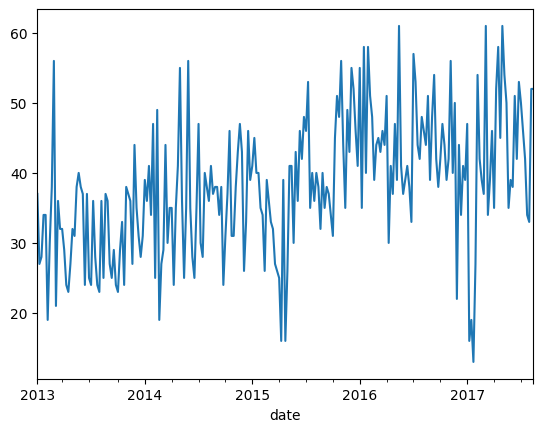

In [ ]:
df_automotive.set_index("date").sales.resample("W-MON").sum().plot()

Dengan melakukan aggregate per 1 minggu kita dapat mengatasi kemunculan data 0 pada awal tahun. <br>
Note : kita mengguanakan argument "W-MON" yang mengindikasikan perhitangan 1 minggu dimulai dari hari senin - minggu, jika default menggunakan W maka perhitungan 1 minggu dimulai dari hari minggu - sabtu

In [ ]:
# Menetapkan 'date' sebagai indeks
df_automotive.set_index("date", inplace=True)

# Meresample berdasarkan minggu dan menjumlahkan nilai 'sales', tetap mempertahankan kolom lainnya
df_automotive = df_automotive.resample("W-MON").agg({
    'sales': 'sum',
})

df_automotive['sales'] = np.log(df_automotive['sales'])
print(df_automotive.head())


               sales
date                
2013-01-07  3.610918
2013-01-14  3.295837
2013-01-21  3.332205
2013-01-28  3.526361
2013-02-04  3.526361


In [ ]:
df_automotive

,sales
date,
2013-01-07,3.610918
2013-01-14,3.295837
2013-01-21,3.332205
2013-01-28,3.526361
2013-02-04,3.526361
...,...
2017-07-17,3.737670
2017-07-24,3.526361
2017-07-31,3.496508


## Uji stationer

In [ ]:
# Split data
# Scalling

scaler = MinMaxScaler()
#df_automotive.drop(['family'], axis=1, inplace=True)
x = df_automotive['sales'].copy()

x = scaler.fit_transform(x.values.reshape(-1, 1))

In [ ]:
def load_data(X, seq_len, train_size=0.8):
    amount_of_features = X.shape[1]
    sequence_length = seq_len + 1
    data = []

    for index in range(len(X) - sequence_length):
        data.append(X[index: index + sequence_length])

    data = np.array(data)
    train_split = int(round(train_size * data.shape[0]))
    train_data = data[:train_split, :]

    x_train = train_data[:, :-1]
    y_train = train_data[:, -1]

    x_test = data[train_split:, :-1]
    y_test = data[train_split:, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

    return x_train, y_train, x_test, y_test

window = 22
X_train, y_train, X_test, y_test = load_data(x, window)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(174, 22, 1) (174, 1) (44, 22, 1) (44, 1)


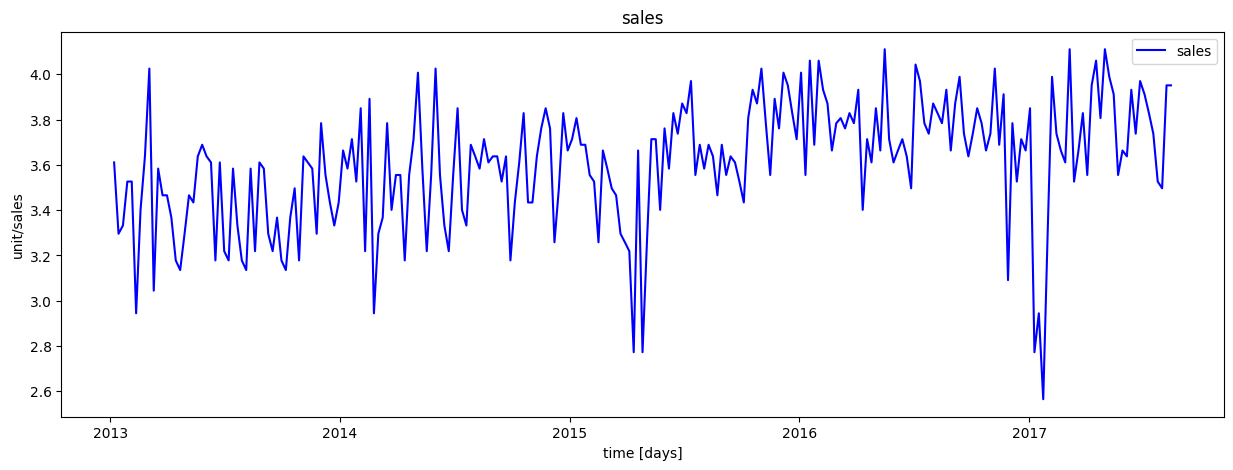

In [ ]:
plt.figure(figsize=(15, 5));
plt.plot(df_automotive['sales'], color='blue', label='sales')

#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('sales')
plt.xlabel('time [days]')
plt.ylabel('unit/sales')
plt.legend(loc='best')
plt.show()

In [ ]:
#LSTM architecture
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(LSTM(units=50, input_shape=(window,1)))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=50, kernel_initializer='uniform', activation='tanh'))
model.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
LSTM=model.fit(X_train,y_train,epochs=100,batch_size=35, validation_split=0.05, verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)

Epoch 1/100
5/5 [==============================] - 5s 213ms/step - loss: 0.4528 - val_loss: 0.5698
Epoch 2/100
5/5 [==============================] - 0s 35ms/step - loss: 0.3873 - val_loss: 0.4532
Epoch 3/100
5/5 [==============================] - 0s 35ms/step - loss: 0.2776 - val_loss: 0.2240
Epoch 4/100
5/5 [==============================] - 0s 32ms/step - loss: 0.0899 - val_loss: 0.0070
Epoch 5/100
5/5 [==============================] - 0s 38ms/step - loss: 0.0695 - val_loss: 0.0174
Epoch 6/100
5/5 [==============================] - 0s 30ms/step - loss: 0.0355 - val_loss: 0.0273
Epoch 7/100
5/5 [==============================] - 0s 37ms/step - loss: 0.0388 - val_loss: 0.0532
Epoch 8/100
5/5 [==============================] - 0s 36ms/step - loss: 0.0384 - val_loss: 0.0203
Epoch 9/100
5/5 [==============================] - 0s 43ms/step - loss: 0.0269 - val_loss: 0.0059
Epoch 10/100
5/5 [==============================] - 0s 40ms/step - loss: 0.0288 - val_loss: 0.0084
Epoch 11/100
5/5 [

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 13001 (50.79 KB)
Trainable params: 13001 (50.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<Axes: >

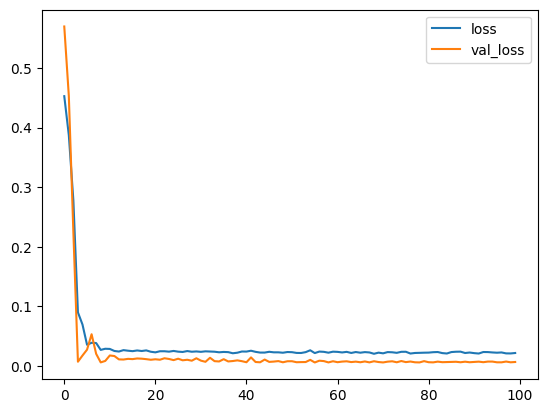

In [ ]:
%matplotlib inline
losses = pd.DataFrame(LSTM.history)
losses.plot()

# model predict

In [ ]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)

2/2 [==============================] - 0s 11ms/step


In [ ]:
plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(44, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(44, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

(44, 1)
(44, 1)


In [ ]:
df_automotive.shape

(241, 1)

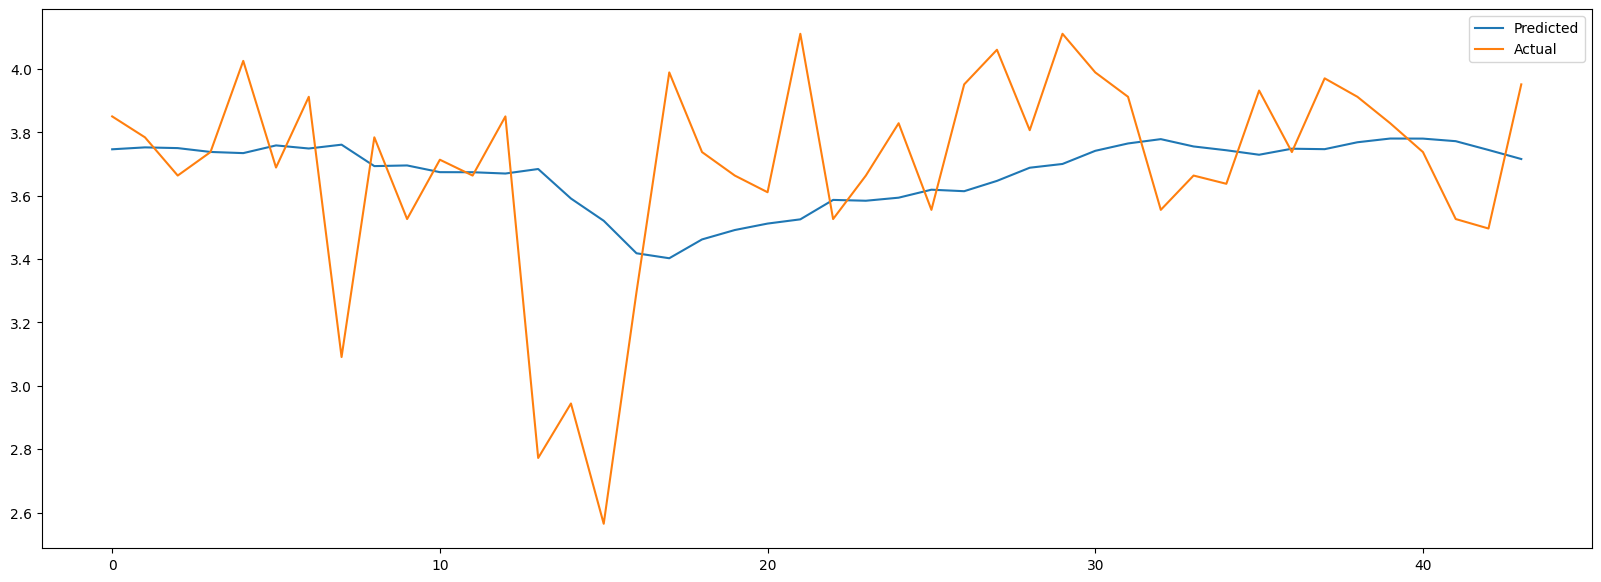

In [ ]:
plot_x = df_store['date'].copy()
plt.figure(figsize=(20,7))
plot_x = pd.to_datetime(plot_x.iloc[-44:])
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [ ]:
trainScore = mean_squared_error(trainY, trainPredict) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY, testPredict) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.22 RMSE
Test Score: 0.32 RMSE


In [ ]:
automotive_sales = df_automotive.sales.values.astype('float32')
automotive_sales = automotive_sales.reshape(len(automotive_sales), 1)
trainPredictPlot = np.empty_like(automotive_sales)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[22:len(trainPredict)+ 22, :] = trainPredict
testPredictPlot = np.empty_like(automotive_sales)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(automotive_sales) - testPredict.shape[0]):len(automotive_sales), :] = testPredict

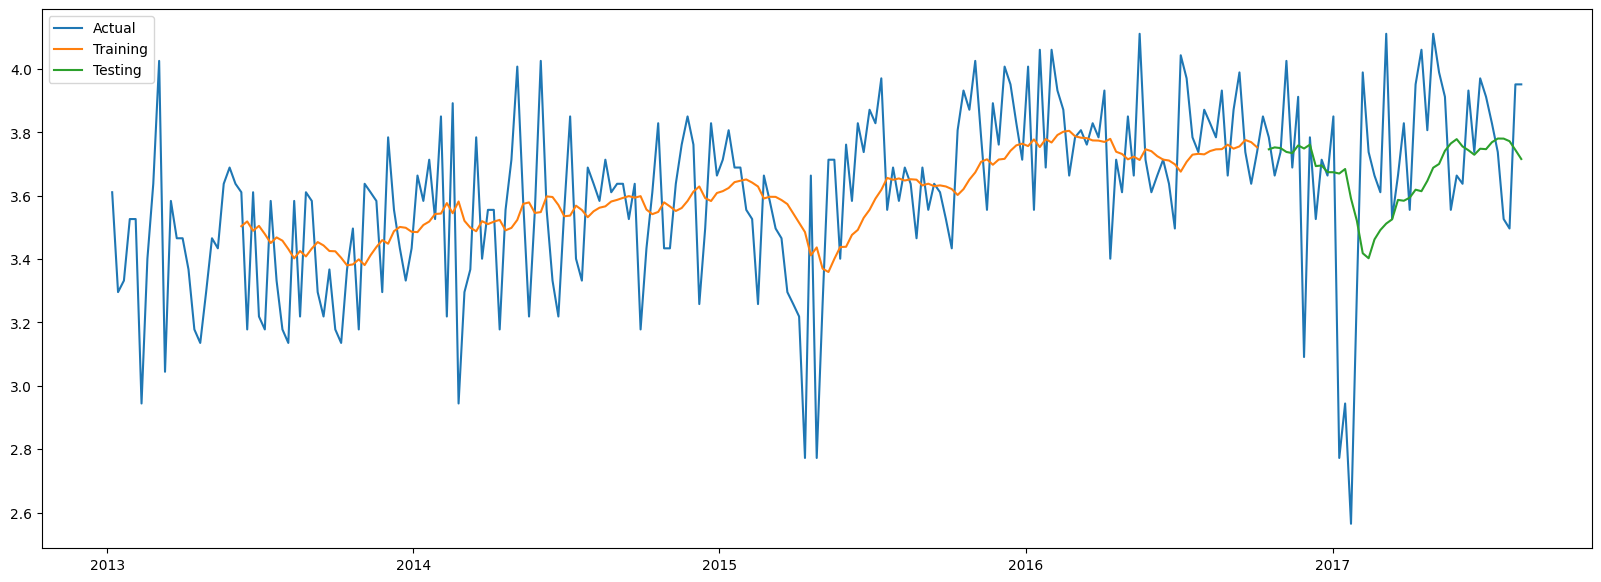

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(automotive_sales, columns=["sales"], index=df_automotive.index).sales, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["sales"], index=df_automotive.index).sales, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["sales"], index=df_automotive.index).sales, label='Testing')
plt.legend(loc='best')
plt.show()

# Model - GRU

In [ ]:
# Stack LSTM architecture
model2 = Sequential()
# GRU layer with Dropout regularisation
model2.add(GRU(units=20, input_shape=(window,1)))
model2.add(Dropout(0.2))

# The output layer
model2.add(Dense(units=20, kernel_initializer='uniform', activation='tanh'))
model2.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
callbacks_list = [earlystop]

# Compiling the RNN
model2.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
start = time.time()
history2=model2.fit(X_train,y_train,epochs=100,batch_size=35, validation_split=0.05, verbose=1,callbacks=callbacks_list)
print ('compilation time : ', time.time() - start)

Epoch 1/100
5/5 [==============================] - 4s 244ms/step - loss: 0.4637 - val_loss: 0.6195
Epoch 2/100
5/5 [==============================] - 0s 35ms/step - loss: 0.4443 - val_loss: 0.5910
Epoch 3/100
5/5 [==============================] - 0s 39ms/step - loss: 0.4202 - val_loss: 0.5531
Epoch 4/100
5/5 [==============================] - 0s 35ms/step - loss: 0.3873 - val_loss: 0.5017
Epoch 5/100
5/5 [==============================] - 0s 31ms/step - loss: 0.3444 - val_loss: 0.4328
Epoch 6/100
5/5 [==============================] - 0s 33ms/step - loss: 0.2892 - val_loss: 0.3441
Epoch 7/100
5/5 [==============================] - 0s 36ms/step - loss: 0.2198 - val_loss: 0.2365
Epoch 8/100
5/5 [==============================] - 0s 28ms/step - loss: 0.1392 - val_loss: 0.1218
Epoch 9/100
5/5 [==============================] - 0s 33ms/step - loss: 0.0616 - val_loss: 0.0323
Epoch 10/100
5/5 [==============================] - 0s 36ms/step - loss: 0.0251 - val_loss: 0.0055
Epoch 11/100
5/5 [

<Axes: >

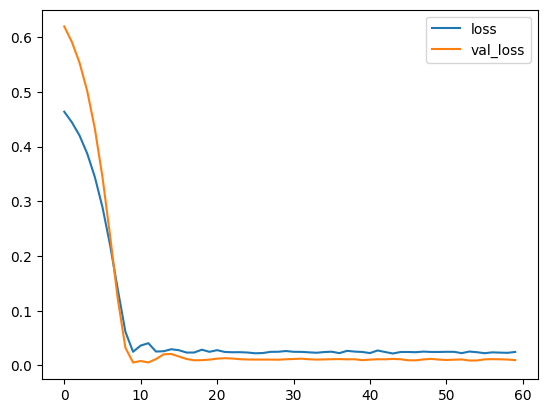

In [ ]:
%matplotlib inline
losses = pd.DataFrame(history2.history)
losses.plot()

In [ ]:
trainPredict = model2.predict(X_train)
testPredict = model2.predict(X_test)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)

2/2 [==============================] - 0s 8ms/step


In [ ]:
trainScore = mean_squared_error(trainY, trainPredict) ** .5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = mean_squared_error(testY, testPredict) ** .5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.22 RMSE
Test Score: 0.31 RMSE


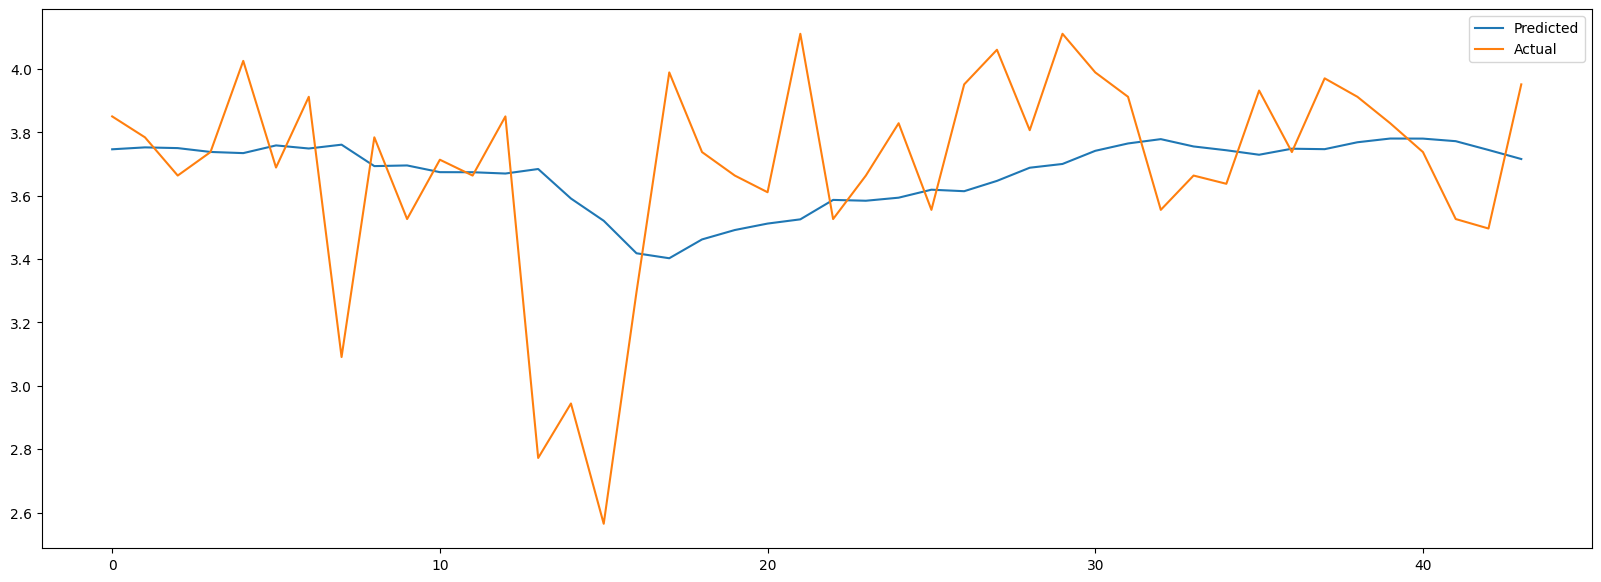

In [ ]:
plt.figure(figsize=(20,7))
plot_x = pd.to_datetime(plot_x.iloc[-174:])
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()